# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git
import sys


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_competition_extention'

In [5]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [6]:
import utilities.helper
import sleap.process_pose

In [7]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
# TONE_TIMESTAMP_DF = pd.read_csv("./proc/rce_tone_timestamp.csv", index_col=0)
# VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("../../proc/video_to_frame_and_subject.xlsx")
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_pickle("./proc/rce2_spectral_granger.pkl")
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
# SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"
SLEAP_DIR = "/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [9]:
START_STOP_FRAME_DF = pd.read_excel("./rce_per_subject_start_stop_video_frame.xlsx").dropna(subset=["file_path"])

In [10]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['cohort', 'session_dir', 'original_file', 'tone_frames',
       'box_1_port_entry_frames', 'box_2_port_entry_frames', 'video_name',
       'session_path', 'recording', 'current_subject', 'subject',
       'all_subjects', 'first_timestamp', 'last_timestamp', 'video_timestamps',
       'tone_timestamps', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'lfp_timestamps', 'mPFC_lfp_trace',
       'MD_lfp_trace', 'LH_lfp_trace', 'BLA_lfp_trace', 'vHPC_lfp_trace',
       'mPFC_power_all_frequencies_all_windows',
       'MD_power_all_frequencies_all_windows',
       'LH_power_all_frequencies_all_windows',
       'BLA_power_all_frequencies_all_windows',
       'vHPC_power_all_frequencies_all_windows', 'power_timestamps',
       'power_calculation_frequencies',
       'BLA_LH_coherence_all_frequencies_all_windows',
       'BLA_MD_coherence_all_frequencies_all_windows',
       'BLA_mPFC_coherence_all_frequencies_all_windows',
       'BLA_vHPC_coherence_all_frequencies_

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [11]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_2"

In [12]:
FULL_LFP_TRACES_PKL = "{}_full_spectral_and_sleap_poses.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Reading in the h5 files between recordings

In [13]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,LH_vHPC_granger_all_frequencies_all_windows,vHPC_LH_granger_all_frequencies_all_windows,MD_mPFC_granger_all_frequencies_all_windows,mPFC_MD_granger_all_frequencies_all_windows,MD_vHPC_granger_all_frequencies_all_windows,vHPC_MD_granger_all_frequencies_all_windows,mPFC_vHPC_granger_all_frequencies_all_windows,vHPC_mPFC_granger_all_frequencies_all_windows,granger_timestamps,granger_calculation_frequencies
0,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,...,"[[1.216, 0.633, 0.282, 0.613, 0.636, 1.501, 0....","[[0.39, 0.2312, 0.02298, 0.1543, 0.315, 0.7856...","[[1.783, 1.615, 1.699, 0.9365, 1.126, 1.648, 0...","[[1.663, 0.849, 1.167, 0.758, 0.328, 0.7144, 1...","[[2.055, 0.452, 0.3164, 0.5933, 0.8477, 0.6006...","[[0.1825, 0.1715, 0.01872, 0.096, 0.2727, 0.36...","[[0.3892, 0.2598, 0.1339, 0.1823, 0.2996, nan,...","[[0.0007057, 0.2181, 0.2163, 0.5986, 0.6187, 0...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,...,"[[2.848, 1.116, 0.682, 0.198, 0.154, 0.127, 0....","[[1.97, 1.198, 0.10645, 0.2512, 0.3628, 0.595,...","[[0.09326, 0.08734, 0.136, 0.0357, 0.1394, 0.2...","[[1.11, 0.2117, 0.3718, 0.1334, 0.174, 0.7544,...","[[1.734, 1.35, 0.8564, 0.2327, 0.08453, 0.0556...","[[1.0205, 0.565, 0.1328, 0.256, 0.311, 0.3535,...","[[1.432, 2.252, 0.566, 0.302, 0.1381, 0.6523, ...","[[nan, 0.8276, 1.56, 0.672, 0.3506, 0.01371, 0...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...","[[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...","[[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....","[[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...","[[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...","[[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...","[[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...","[[0.386, 0.0818, 0.07935, 0.03128, 0.2976, 1.4...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[[0.05106, 0.03592, 0.804, 1.848, 0.3523, 1.55...","[[0.5166, nan, 0.236, 0.238, 0.282, 1.07, 0.03...","[[2.38, nan, 0.556, 0.719, 0.4656, 1.49, 1.627...","[[0.828, 0.4062, 0.2362, 0.0009437, 0.02545, 0...","[[0.

- Getting the names of each subject

In [14]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].unique()

array(['20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.3',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.2',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.2',
       '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_and_1-2.1',
       '20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_and_1-4.1',
       '20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_and_1-4.1',
       '20230628_111202

In [15]:
glob.glob(SLEAP_DIR+ "/*/*2_subj*.h5")

['/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.2_subj.id_corrected.h5',
 '/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.3.fixed.2_subj.round_1.id_corrected.h5',
 '/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.1_subj.round_1.id_corrected.h5',
 '/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.corner.h5',
 '/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_correc

In [16]:
SLEAP_DIR

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected'

In [17]:
# VIDEO_TO_FRAME_AND_SUBJECT_DF["video_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: os.path.join(SLEAP_DIR, "*", x + "*.h5"))
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "*", x + "*2_subj*.h5")))
# VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: os.path.join(SLEAP_DIR, "*", x + "*2_subj*.h5"))


In [18]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF[VIDEO_TO_FRAME_AND_SUBJECT_DF['sleap_glob'].apply(lambda x: len(x) >= 1)]
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.reset_index(drop=True)


VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"].apply(lambda x: x[0])

In [19]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,MD_mPFC_granger_all_frequencies_all_windows,mPFC_MD_granger_all_frequencies_all_windows,MD_vHPC_granger_all_frequencies_all_windows,vHPC_MD_granger_all_frequencies_all_windows,mPFC_vHPC_granger_all_frequencies_all_windows,vHPC_mPFC_granger_all_frequencies_all_windows,granger_timestamps,granger_calculation_frequencies,sleap_glob,sleap_path
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....","[[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...","[[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...","[[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...","[[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...","[[0.386, 0.0818, 0.07935, 0.03128, 0.2976, 1.4...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[[2.38, nan, 0.556, 0.719, 0.4656, 1.49, 1.627...","[[0.828, 0.4062, 0.2362, 0.0009437, 0.02545, 0...","[[0.02159, 0.06714, 0.8926, 1.809, 0.4932, 1.3...","[[0.7085, nan, 0.1938, 0.2976, 0.1993, 1.26, 0...","[[0.003847, 0.1844, 0.7407, 1.28, 0.6084, 0.62...","[[0.6704, 1.331, 0.391, 0.0775, 0.07806, 0.180...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,"[[0.01987, 0.04828, 0.05753, 0.2135, 1.297, 0....","[[0.616, 0.586, 0.397, 0.578, 0.4282, 0.2123, ...","[[0.267, 0.07654, 0.11566, 0.3652, 0.2986, 0.1...","[[0.03732, 0.8257, 0.9805, 0.1819, 0.174, 1.07...","[[2.346, 0.00597, 0.05408, 0.03165, 0.1912, 0....","[[0.0721, 0.717, 1.041, 0.581, 0.3962, 0.6646,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,"[[1.888, 1.042, 2.107, 0.1367, 0.0794, 0.04163...","[[0.9297, 0.2365, 0.7144, 0.544, 0.515, 0.0935...","[[1.492, 0.1307, 0.2512, 0.0712, 0.1033, 0.235...","[[2.883, 1.061, 1.037, 0.4072, 1.512, 0.1975, ...","[[1.2295, 0.05807, 0.4219, 0.07153, 0.3962, 0....","[[2.28, 1.299, 0.6606, 0.4128,

In [20]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [21]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [23]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                           [1.1, 1.2]
1                                           [1.1, 1.2]
2    [1.4, 1.1, track_901, track_902, track_903, tr...
3    [1.4, 1.1, track_901, track_902, track_903, tr...
4    [1.2, 1.4, track_685, track_686, track_687, tr...
5    [1.2, 1.4, track_685, track_686, track_687, tr...
6    [1.1, 1.4, track_867, track_868, track_869, tr...
7    [1.1, 1.4, track_867, track_868, track_869, tr...
Name: track_names, dtype: object

In [24]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_sleap_track_names_from_h5(x))

In [25]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"].iloc[0].shape

(68258, 6, 2, 2)

In [26]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"].iloc[0]

['1.1', '1.2']

In [27]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject"]

0    1.1
1    1.2
2    1.1
3    1.4
4    1.2
5    1.4
6    1.1
7    1.4
Name: subject, dtype: object

In [28]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                           [1.1, 1.2]
1                                           [1.1, 1.2]
2    [1.4, 1.1, track_901, track_902, track_903, tr...
3    [1.4, 1.1, track_901, track_902, track_903, tr...
4    [1.2, 1.4, track_685, track_686, track_687, tr...
5    [1.2, 1.4, track_685, track_686, track_687, tr...
6    [1.1, 1.4, track_867, track_868, track_869, tr...
7    [1.1, 1.4, track_867, track_868, track_869, tr...
Name: track_names, dtype: object

In [29]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["all_subjects"] if k in x["track_names"]}, axis=1)

In [30]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 1, '1.4': 0}
3    {'1.1': 1, '1.4': 0}
4    {'1.2': 0, '1.4': 1}
5    {'1.2': 0, '1.4': 1}
6    {'1.1': 0, '1.4': 1}
7    {'1.1': 0, '1.4': 1}
Name: subject_to_index, dtype: object

In [31]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [32]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 1, '1.4': 0}
3    {'1.1': 1, '1.4': 0}
4    {'1.2': 0, '1.4': 1}
5    {'1.2': 0, '1.4': 1}
6    {'1.1': 0, '1.4': 1}
7    {'1.1': 0, '1.4': 1}
Name: subject_to_tracks, dtype: object

In [33]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [34]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[331.99508667 127.74658203], [307.31...
1    {'1.1': [[[331.99508667 127.74658203], [307.31...
2    {'1.1': [[[336.33197021 400.23355103], [319.35...
3    {'1.1': [[[336.33197021 400.23355103], [319.35...
4    {'1.2': [[[367.69689941 343.70245361], [399.40...
5    {'1.2': [[[367.69689941 343.70245361], [399.40...
6    {'1.1': [[[340.27038574 388.14276123], [324.34...
7    {'1.1': [[[340.27038574 388.14276123], [324.34...
Name: subject_to_tracks, dtype: object

In [35]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,vHPC_mPFC_granger_all_frequencies_all_windows,granger_timestamps,granger_calculation_frequencies,sleap_glob,sleap_path,all_sleap_data,locations,track_names,subject_to_index,subject_to_tracks
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[[0.386, 0.0818, 0.07935, 0.03128, 0.2976, 1.4...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[331.99508667 127.74658203], [307.31..."
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[[0.6704, 1.331, 0.391, 0.0775, 0.07806, 0.180...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[331.99508667 127.74658203], [307.31..."
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,"[[0.0721, 0.717, 1.041, 0.581, 0.3962, 0.6646,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[364.50231934 336.33197021 ...,[[[[364.50231934 336.33197021 nan ...,"[1.4, 1.1, track_901, track_902, track_903, tr...","{'1.1': 1, '1.4': 0}","{'1.1': [[[336.33197021 400.23355103], [319.35..."
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,"[[2.28, 1.299, 0.6606, 0.4128, 0.6216, 0.0938,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[364.50231934 336.33197021 ...,[[[[364.50231934 336.33197021 nan ...,"[1.4, 1.1, track_901, track_902, track_903, tr...","{'1.1': 1, '1.4': 0}","{'1.1': [[[336.33197021 400.23355103], [319.35..."
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[33

## Getting the coordinates of the corners

In [36]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[0]

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.2_subj.id_corrected.h5'

In [37]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".1_subj", "").replace(".2_subj", ""))


In [38]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5'

In [39]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [40]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0    [box_top_left, box_top_right, reward_port, box...
1    [box_top_left, box_top_right, reward_port, box...
2    [box_bottom_left, box_top_right, reward_port, ...
3    [box_bottom_left, box_top_right, reward_port, ...
4    [box_bottom_left, box_top_right, reward_port, ...
5    [box_bottom_left, box_top_right, reward_port, ...
6    [box_top_left, box_bottom_right, box_bottom_le...
7    [box_top_left, box_bottom_right, box_bottom_le...
Name: corner_parts, dtype: object

In [41]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [42]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [43]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
1    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
2    {'box_bottom_left': [[[219.49634883], [382.936...
3    {'box_bottom_left': [[[219.49634883], [382.936...
4    {'box_bottom_left': [[[220.39193729], [383.559...
5    {'box_bottom_left': [[[220.39193729], [383.559...
6    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
7    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
Name: corner_to_coordinate, dtype: object

In [44]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [45]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[0]

{'box_top_left': array([215.09666221, 113.92341628]),
 'box_top_right': array([425.34565573, 112.24884398]),
 'reward_port': array([321.65255293, 398.27617649]),
 'box_bottom_left': array([216.58701461, 380.2771342 ]),
 'box_bottom_right': array([425.87477825, 379.32621417])}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [46]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [47]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [48]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [49]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [50]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0    0.089984
1    0.089984
2    0.091180
3    0.091180
4    0.090895
5    0.090895
6    0.092440
7    0.092440
Name: height_ratio, dtype: float64

In [51]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0    0.140631
1    0.140631
2    0.138909
3    0.138909
4    0.140325
5    0.140325
6    0.137652
7    0.137652
Name: width_ratio, dtype: float64

## Converting Pixels to cm

- Converting the X-dimension

In [52]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[331.99508667 127.74658203], [307.31...
1    {'1.1': [[[331.99508667 127.74658203], [307.31...
2    {'1.1': [[[336.33197021 400.23355103], [319.35...
3    {'1.1': [[[336.33197021 400.23355103], [319.35...
4    {'1.2': [[[367.69689941 343.70245361], [399.40...
5    {'1.2': [[[367.69689941 343.70245361], [399.40...
6    {'1.1': [[[340.27038574 388.14276123], [324.34...
7    {'1.1': [[[340.27038574 388.14276123], [324.34...
Name: subject_to_tracks, dtype: object

In [53]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,corner_parts,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[box_top_left, box_top_right, reward_port, box...","{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[box_top_left, box_top_right, reward_port, box...","{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [220.39193729003364, 383.5...",210.104174,210.347858,266.915505,261.168378,264.041942,210.226016,0.140325,0.090895
5,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [220.39193729003364, 383.5...",210.104174,210.347858,266.915505,261.168378,264.041942,210.226016,0.140325,0.090895
6,2,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_c

In [54]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [55]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [56]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [215.09666220678088, 113.9234...
1    {'box_top_left': [215.09666220678088, 113.9234...
2    {'box_bottom_left': [219.49634882813532, 382.9...
3    {'box_bottom_left': [219.49634882813532, 382.9...
4    {'box_bottom_left': [220.39193729003364, 383.5...
5    {'box_bottom_left': [220.39193729003364, 383.5...
6    {'box_top_left': [210.30936448661504, 125.0467...
7    {'box_top_left': [210.30936448661504, 125.0467...
Name: corner_to_coordinate, dtype: object

In [57]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778..."
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778..."
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,"{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101..."
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,"{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101..."
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,...,"{'box_bottom_left': [220.39193729003364, 383.5...",210.104174,210.347858,266.915505,261.168378,264.041942,210.226016,0.140325,0.090895,"{'1.2': [[[51.59712735 31.24071437], [56.04655..."
5,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,...,"{'box_bottom_left': [220.39193729003364, 383.5...",210.104174,210.347858,266.915505,261.168378,264.041942,210.226016,0.140325,0.090895,"{'1.2': [[[51.59712735 31.24071437], [56.04655..."
6,2,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_stan

In [58]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

In [59]:
normalized

,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
1,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
2,"[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"
3,"[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"
4,"[212.83603592935802, 122.39141193180859]","[423.18389396092107, 116.66556589348068]","[325.63401433242996, 402.62634884460994]","[220.39193729003364, 383.5597902192847]","[430.4961117683324, 383.58107124071535]"
5,"[212.83603592935802, 122.39141193180859]","[423.18389396092107, 116.66556589348068]","[325.63401433242996, 402.62634884460994]","[220.39193729003364, 383.5597902192847]","[430.4961117683324, 383.58107124071535]"
6,"[210.30936448661504, 125.04673201622876]","[423.21999535014805, 119.91743018428687]","[323.9681885492672, 403.40074541633544]","[216.44422093087914, 381.6053799064849]","[432.1500559910414, 382.6164985908858]"
7,"[210.30936448661504, 125.04673201622876]","[423.21999535014805, 119.91743018428687]","[323.9681885492672, 403.40074541633544]","[216.44422093087914, 381.6053799064849]","[432.1500559910414, 382.6164985908858]"


In [60]:


# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [61]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,...,264.041942,210.226016,0.140325,0.090895,"{'1.2': [[[51.59712735 31.24071437], [56.04655...","[212.83603592935802, 122.39141193180859]","[423.18389396092107, 116.66556589348068]","[325.63401433242996, 402.62634884460994]","[220.39193729003364, 383.5597902192847]","[430.4961117683324, 383.58107124071535]"


In [62]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

In [63]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]"
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]"
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,...,264.041942,210.226016,0.140325,0.090895,"{'1.2': [[[51.59712735 31.24071437], [56.04655...","[29.86625143627433, 11.124724603015066]","[59.38334890344171, 10.604275828952773]","[45.69464614292888, 36.59658123160905]","[30.926534526401632, 34.86353305048207]","[60.40943705923425, 34.86546738148577]"
5,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287]

## Looking over the tracks

In [64]:
FILE_INDEX = 0

In [65]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX]

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.2_subj.id_corrected.h5'

In [66]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"]

0    {'1.1': [[[46.68890098 11.49508545], [43.21778...
1    {'1.1': [[[46.68890098 11.49508545], [43.21778...
2    {'1.1': [[[46.71964111 36.49337937], [44.36101...
3    {'1.1': [[[46.71964111 36.49337937], [44.36101...
4    {'1.2': [[[51.59712735 31.24071437], [56.04655...
5    {'1.2': [[[51.59712735 31.24071437], [56.04655...
6    {'1.1': [[[46.8389676  35.87977984], [44.64656...
7    {'1.1': [[[46.8389676  35.87977984], [44.64656...
Name: rescaled_locations, dtype: object

In [67]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject"]

0    1.1
1    1.2
2    1.1
3    1.4
4    1.2
5    1.4
6    1.1
7    1.4
Name: subject, dtype: object

In [68]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject"].iloc[FILE_INDEX]
    locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68258, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [69]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

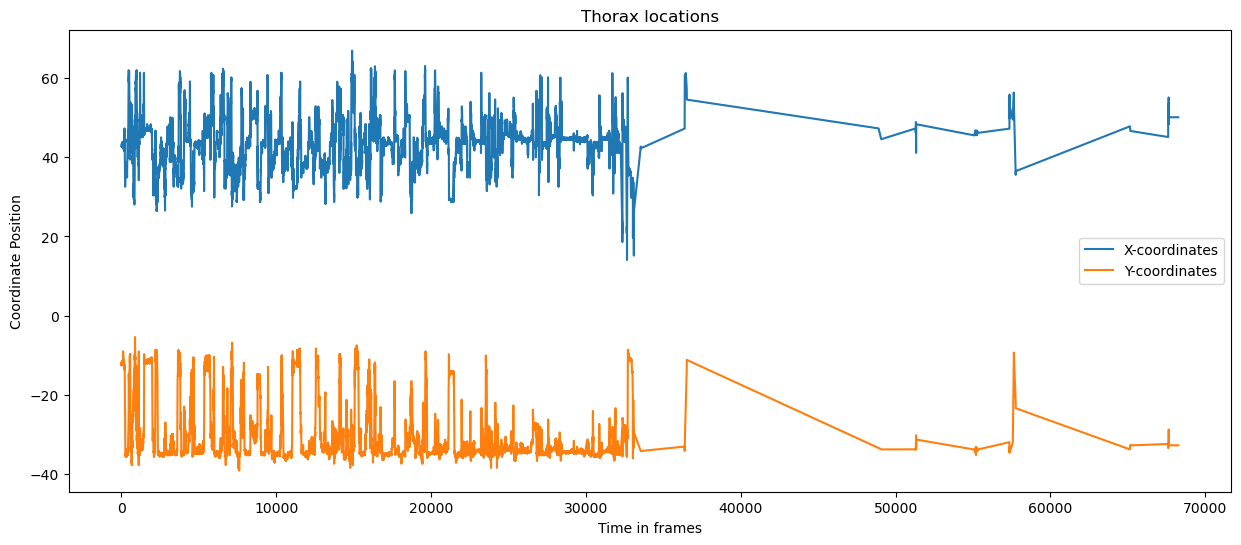

In [70]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

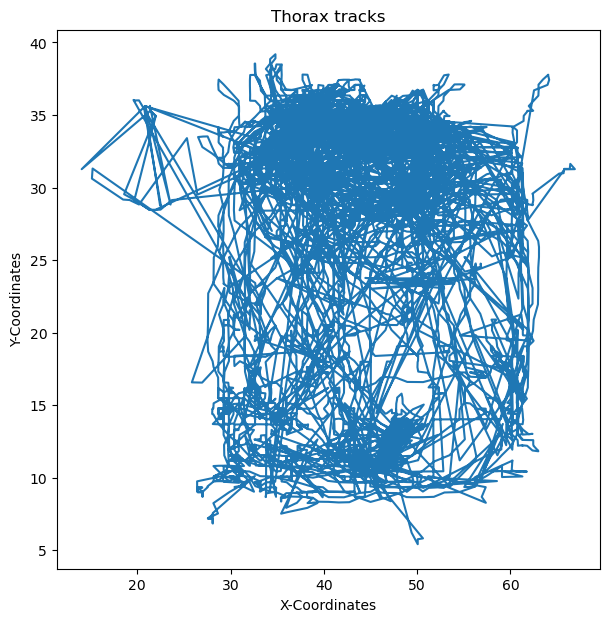

In [71]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [72]:
# VIDEO_TO_FRAME_AND_SUBJECT_DF["agent"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: list(set(x["all_subjects"]) - set(x["subject"]))[0], axis=1)

VIDEO_TO_FRAME_AND_SUBJECT_DF["agent"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: list((set(x["all_subjects"]) - set([x["subject"]])))[0], axis=1)

In [73]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.4
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.1
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,...,210.226016,0.140325,0.090895,"{'1.2': [[[51.59712735 31.24071437], [56.04655...","[29.86625143627433, 11.124724603015066]","[59.38334890344171, 10.604275828952773]","[45.69464614292888, 36.59658123160905]","[30.926534526401632, 34.86353305048207]","[60.40943705923425, 34.86546738148577]",1.4
5,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[

In [74]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x["rescaled_locations"][x["subject"]] , axis=1)

In [75]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["agent_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x["rescaled_locations"][x["agent"]] , axis=1)

## Removing unnecessary columns

In [76]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'current_subject', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [77]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['cohort', 'session_dir', 'original_file', 'tone_frames',
       'box_1_port_entry_frames', 'box_2_port_entry_frames', 'video_name',
       'session_path', 'recording', 'subject', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'video_timestamps',
       'tone_timestamps', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'lfp_timestamps', 'mPFC_lfp_trace',
       'MD_lfp_trace', 'LH_lfp_trace', 'BLA_lfp_trace', 'vHPC_lfp_trace',
       'mPFC_power_all_frequencies_all_windows',
       'MD_power_all_frequencies_all_windows',
       'LH_power_all_frequencies_all_windows',
       'BLA_power_all_frequencies_all_windows',
       'vHPC_power_all_frequencies_all_windows', 'power_timestamps',
       'power_calculation_frequencies',
       'BLA_LH_coherence_all_frequencies_all_windows',
       'BLA_MD_coherence_all_frequencies_all_windows',
       'BLA_mPFC_coherence_all_frequencies_all_windows',
       'BLA_vHPC_coherence_all_frequencies_all_windows',
     

In [78]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,subject,...,granger_timestamps,granger_calculation_frequencies,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations
0,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34..."
1,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43..."
2,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,...,"[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.4,"[[[46.71964110607613, 36.493379374373234], [44...","[[[50.63276479731981, 10.511614189582007], [51..."
3,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,...,"[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.1,"[[[50.63276479731981, 10.511614189582007], [51...","[[[46.71964110607613, 36.493379374373234], [44..."
4,2,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competiti

# Adding the start/stop frame information

In [79]:
START_STOP_FRAME_DF.head()

,file_path,start_frame,stop_frame,tracked_subject,in_video_subjects,notes
1,/scratch/back_up/reward_competition_extention/...,1.0,25000.0,6.3,6.1_6.3,NaN
2,/scratch/back_up/reward_competition_extention/...,27500.0,73600.0,6.1_6.3,6.1_6.3,NaN
3,/scratch/back_up/reward_competition_extention/...,51500.0,76454.0,6.3,6.1_6.3,NaN
4,/scratch/back_up/reward_competition_extention/...,1.0,48500.0,6.1_6.3,6.1_6.3,NaN
5,/scratch/back_up/reward_competition_extention/...,41000.0,79050.0,1.1,1.1_1.2,NaN


- Getting relevant metadata for each video

In [80]:
# Getting all the rows that have two subjects
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: len(x) == 2)]

In [81]:
# Getting the sleap filename from file path
START_STOP_FRAME_DF["sleap_filename"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))

In [82]:
# Getting the sleap fileroot from the sleap filename
START_STOP_FRAME_DF["sleap_fileroot"] = START_STOP_FRAME_DF["sleap_filename"].apply(lambda x: ".".join(x.split(".")[0:2]))

In [83]:
# Combining the start and stop frame columns into a tuple
START_STOP_FRAME_DF["start_stop_frame"] = START_STOP_FRAME_DF.apply(lambda x: (int(x["start_frame"]), int(x["stop_frame"])), axis=1)
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["start_frame", "stop_frame"], errors="ignore")

- Merging the dataframes based on shared SLEAP file basename

In [84]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.merge(left=VIDEO_TO_FRAME_AND_SUBJECT_DF, right=START_STOP_FRAME_DF, left_on="video_name", right_on="sleap_fileroot", how="left")

- Converting the start/stop frames into timestamps

In [85]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_stop_timestamps"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: (x["video_timestamps"][x["start_stop_frame"][0]], x["video_timestamps"][x["start_stop_frame"][1]]), axis=1)

## Exporting

In [88]:
FULL_LFP_TRACES_PKL

'rce_pilot_2_full_spectral_and_sleap_poses.pkl'

In [89]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['cohort', 'session_dir', 'original_file', 'tone_frames',
       'box_1_port_entry_frames', 'box_2_port_entry_frames', 'video_name',
       'session_path', 'recording', 'subject', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'video_timestamps',
       'tone_timestamps', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'lfp_timestamps', 'mPFC_lfp_trace',
       'MD_lfp_trace', 'LH_lfp_trace', 'BLA_lfp_trace', 'vHPC_lfp_trace',
       'mPFC_power_all_frequencies_all_windows',
       'MD_power_all_frequencies_all_windows',
       'LH_power_all_frequencies_all_windows',
       'BLA_power_all_frequencies_all_windows',
       'vHPC_power_all_frequencies_all_windows', 'power_timestamps',
       'power_calculation_frequencies',
       'BLA_LH_coherence_all_frequencies_all_windows',
       'BLA_MD_coherence_all_frequencies_all_windows',
       'BLA_mPFC_coherence_all_frequencies_all_windows',
       'BLA_vHPC_coherence_all_frequencies_all_windows',
     

In [90]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [86]:
raise ValueError()

ValueError: 

## Going from frame information to ephys

# Filtering for parts of the video

In [ ]:
for trace_col in [col for col in VIDEO_TO_FRAME_AND_SUBJECT_DF.columns if "lfp_trace" in col]:
    print(trace_col)
    brain_region = trace_col.split("_")[0]
    VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_{}_trace".format(brain_region)] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["lfp_timestamps"], x[trace_col])[1], axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_lfp_timestamps"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["lfp_timestamps"], x["lfp_timestamps"])[0], axis=1)

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=[col for col in VIDEO_TO_FRAME_AND_SUBJECT_DF.columns if "lfp_trace" in col], errors="ignore")
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["lfp_timestamps"], errors="ignore")

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_timestamps"].iloc[0]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_timestamps"].apply(lambda x: x.shape)

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"].apply(lambda x: x.shape)

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["recording"].iloc[5]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_subject_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["video_timestamps"], x["subject_locations"])[1], axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_agent_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["video_timestamps"], x["agent_locations"])[1], axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_video_timestamps"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["video_timestamps"], x["video_timestamps"])[0], axis=1)

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["video_timestamps", "subject_locations", "agent_locations"], errors="ignore")

In [ ]:
# Sorting column names for easier reading
sorted_columns = sorted(VIDEO_TO_FRAME_AND_SUBJECT_DF.columns, key=lambda x: x.split("_")[-1])

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF[sorted_columns].copy()

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

In [ ]:
raise ValueError()

In [ ]:
def find_nearest_timestamp_indices(timestamps, other_timestamps, start_index=0, stop_index=1):
    """
    Converts the start and stop indices of one data stream to timestamps, and then finds the nearest start and stop 
    timestamps in another data stream.

    Parameters:
    - timestamps (list[int or float]): The list of timestamps in the first data stream.
    - other_timestamps (list[int or float]): The list of timestamps in the other data stream.
    - start_index (int, optional): The start index in the first data stream. Defaults to 0.
    - stop_index (int, optional): The stop index in the first data stream. Defaults to 1.

    Returns:
    - tuple: The indices of the nearest start and stop timestamps in the other data stream.
    """
    # Convert start and stop indices to timestamps
    start_timestamp = timestamps[start_index]
    stop_timestamp = timestamps[stop_index]

    # Find nearest start and stop timestamps in other data stream
    nearest_start_index = utilities.helper.find_nearest_index(other_timestamps, start_timestamp)
    nearest_stop_index = utilities.helper.find_nearest_index(other_timestamps, stop_timestamp) 

    return nearest_start_index, nearest_stop_index